# Estimate Home Tax Values in Zillow
Authors: Matthew Mays, Gilbert Noriega

## Goals
- Our goal for this project is to create a model that will predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the months of May and June in 2017.

## Import Modules:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from acquire import get_zillow_data
from prepare import prep_zillow_final, zillow_split, add_scaled_columns
from model import plot_variable_pairs
from model import select_kbest, rfe
from model import linearReg_train, lassoLars_train, poly_linearReg_train
from model import linearReg_validate, lassoLars_validate, poly_linearReg_validate

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

## Data Acquire

- Our function, **get_zillow_data**, uses the SQL query we created to bring in data from the Zillow database to include only single unit residential properties whose last transactions were in the months of May and June in 2017. We joined a table to get the last transaction which gave us a total row count of 15,036.

## Data Prep

In [2]:
df = prep_zillow_final()
train, validate, test = zillow_split(df)

## Data Exploration

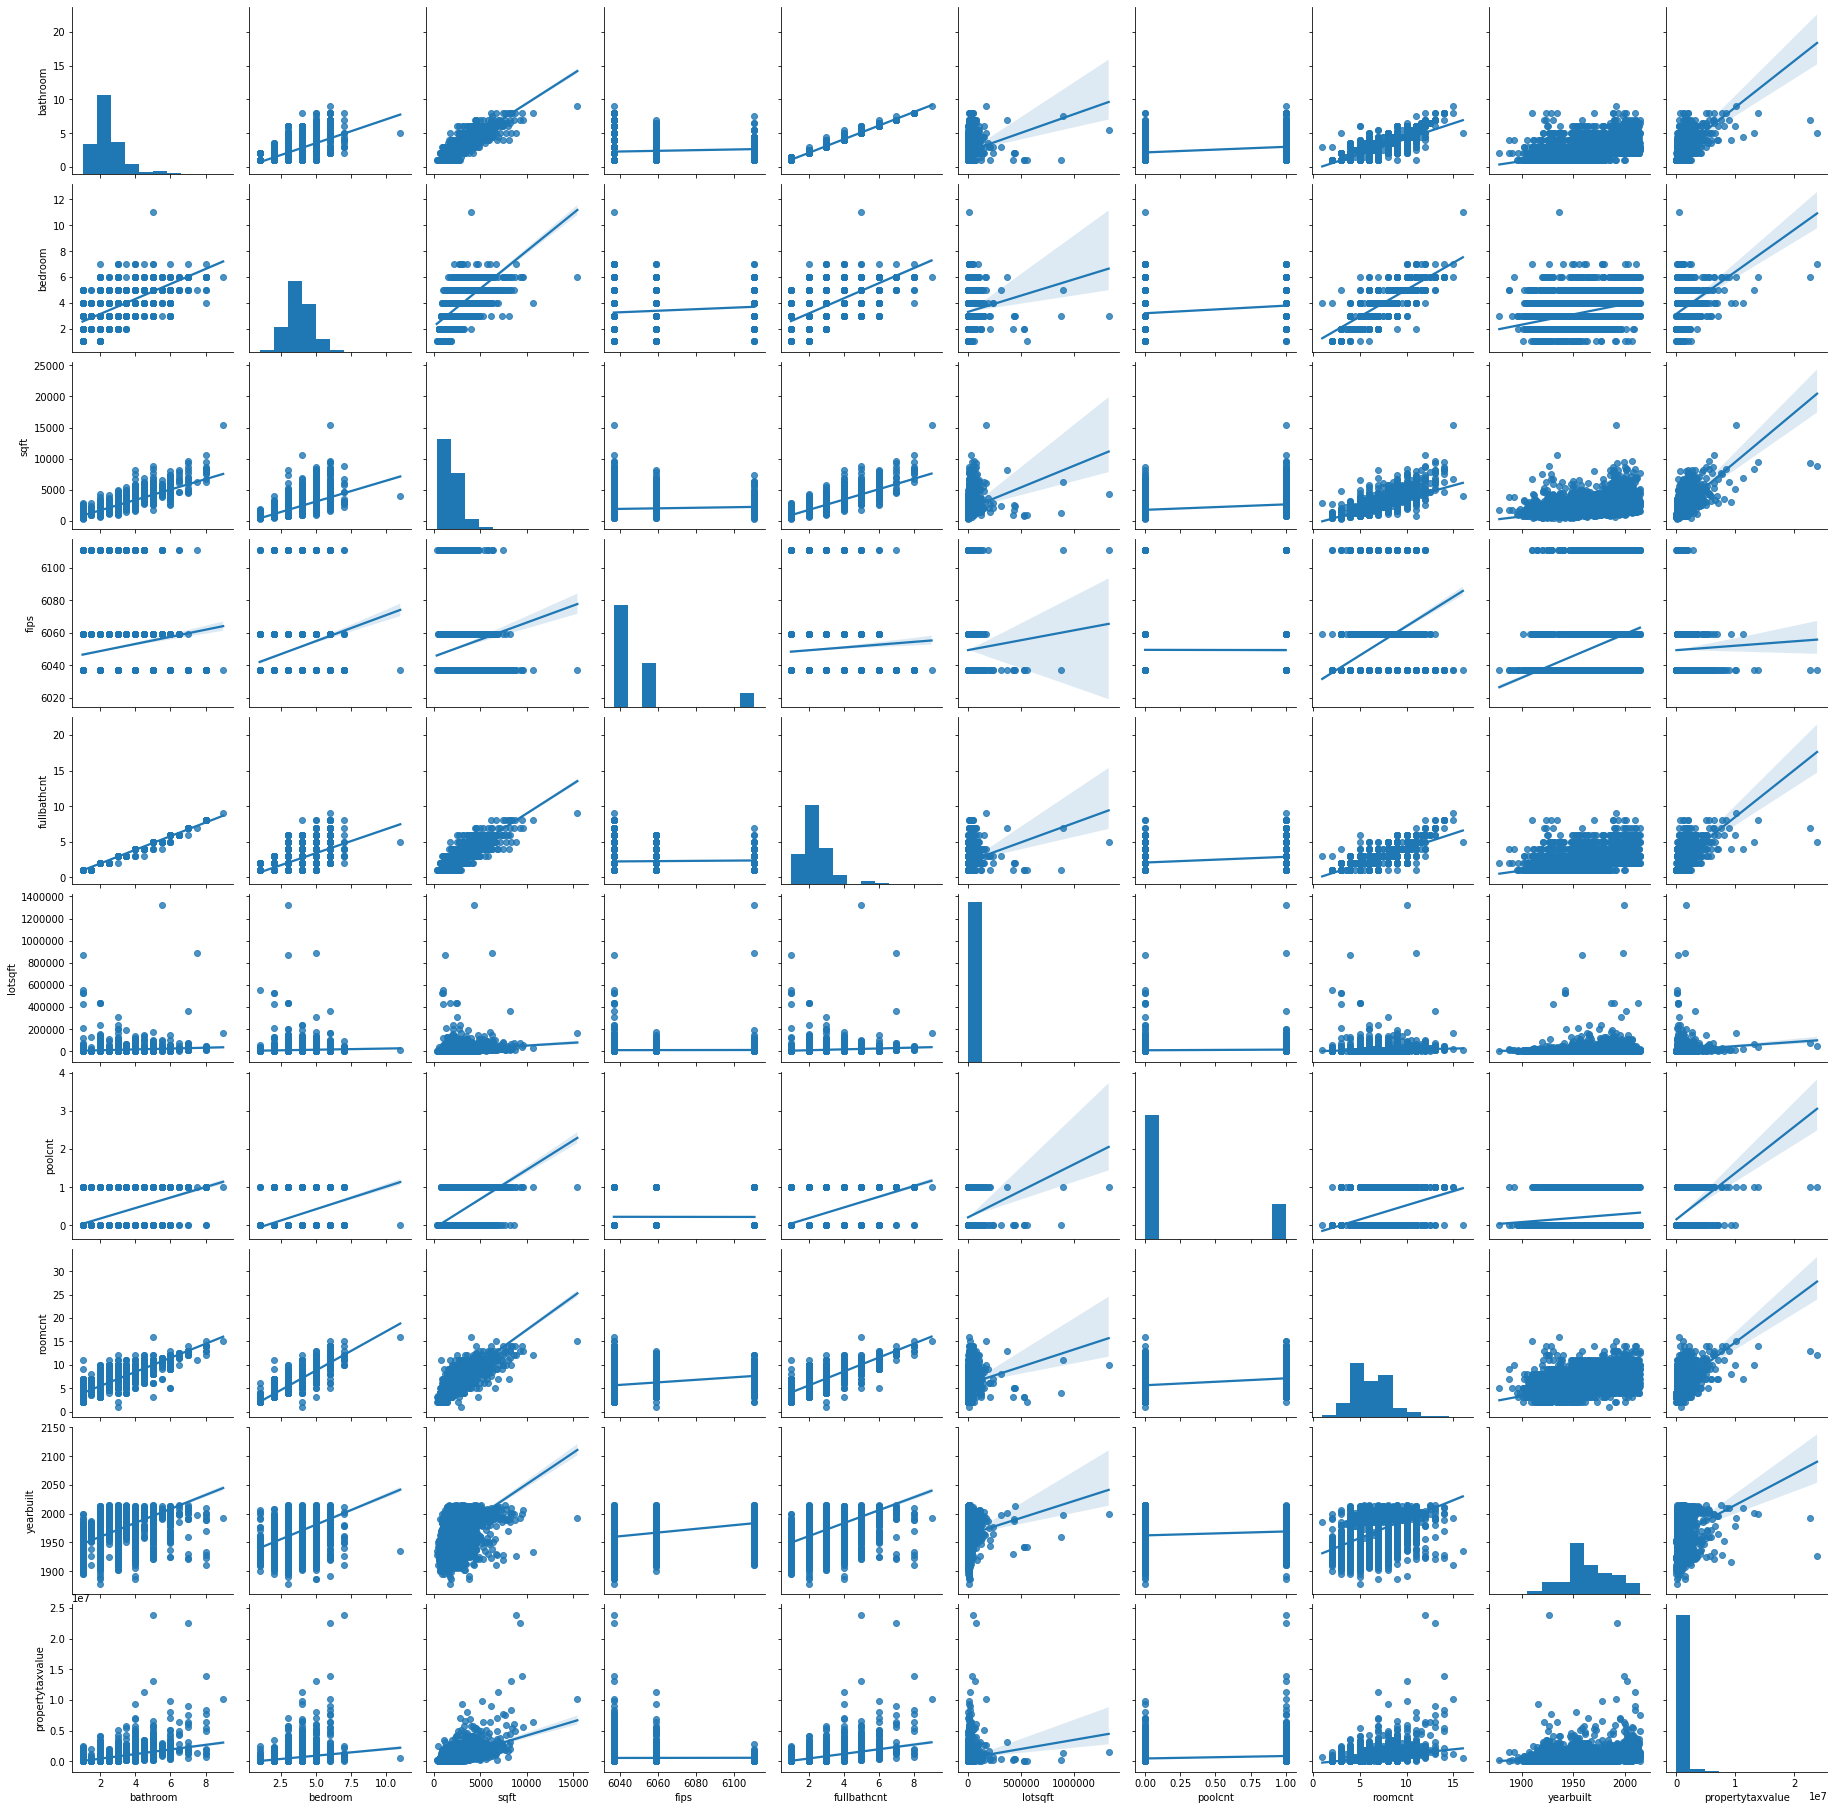

In [3]:
plot_variable_pairs(train)
plt.show()

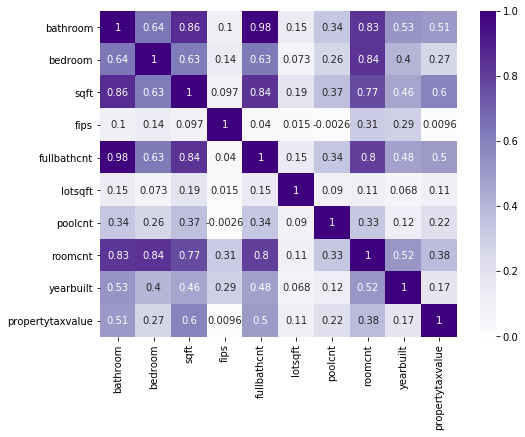

In [4]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Purples', annot=True)
plt.show()

### Is tax value independent from the amount of bedrooms?

##### Hypothesis 1:

$H_0$: Tax value and the amount of bedrooms are **independent**

$H_a$: Tax value and the amount of bedrooms are **dependent**

##### Assigning test variables

In [5]:
x = train.bedroom
y = train.propertytaxvalue

##### Setting Alpha

In [6]:
alpha = .05

##### Running Correlation Test

In [7]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.26526650965341286, 1.4902832593339113e-143)

##### Analyzing the Results

In [8]:
print('Correlation between tax value and bedrooms')
print(f'  r = {corr:.3f}')

Correlation between tax value and bedrooms
  r = 0.265


In [9]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.4902832593339113e-143

###### Conclusion: The tax value and the amount of bedrooms are dependent

### Do homes with pools have a different tax value than those without pools?

##### Hypothesis 2
$H_0$: There is **no difference** in tax value between houses with pools and houses without pools

$H_a$: There is **a difference** in tax value between houses with pools and houses without pools

In [10]:
taxvalue_with_pool = train[train.poolcnt == 1].propertytaxvalue
taxvalue_without_pool = train[train.poolcnt == 0].propertytaxvalue

**Plot Distribution**

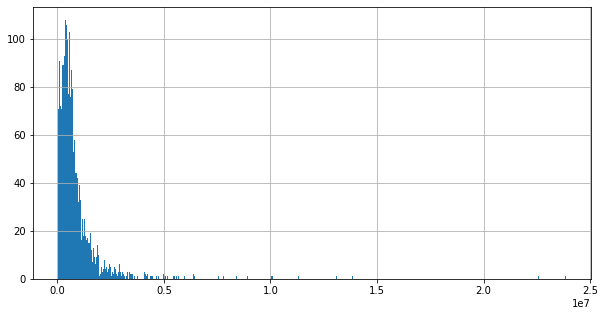

In [11]:
plt.figure(figsize=(10,5))
taxvalue_with_pool.hist(bins = 500)
plt.show()

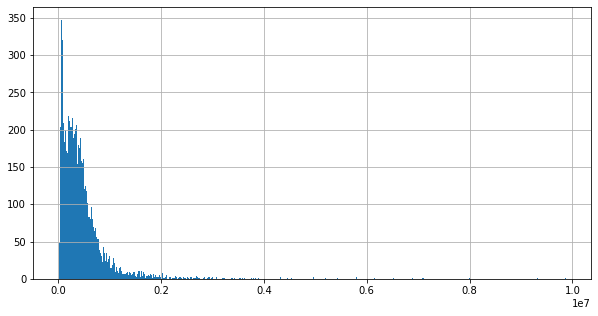

In [12]:
plt.figure(figsize=(10,5))
taxvalue_without_pool.hist(bins = 500)
plt.show()

**Equal Variance?**

In [13]:
taxvalue_with_pool.var()

1494201814857.4915

In [14]:
taxvalue_without_pool.var()

265163532323.93182

In [15]:
t, p = stats.ttest_ind(taxvalue_with_pool, taxvalue_without_pool, equal_var = False)
t, p

(14.109242624050193, 2.5858175318036635e-43)

In [16]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null")

We reject the null hypothesis


###### Conclusion: There is a difference in tax value between houses with pools and houses without pools

## Feature Engineering

In [17]:
train.head()

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
12272,1.0,2.0,1060.0,6037.0,1.0,4795.0,0.0,3.0,1935.0,196289.0
13496,3.0,5.0,2115.0,6037.0,3.0,5866.0,1.0,8.0,1989.0,440315.0
14068,3.0,5.0,2186.0,6037.0,3.0,5109.0,1.0,8.0,1952.0,1120188.0
9126,2.0,3.0,1720.0,6037.0,2.0,10118.0,0.0,5.0,1956.0,81697.0
4840,2.5,4.0,2494.0,6059.0,2.0,6200.0,0.0,9.0,1966.0,113621.0


In [18]:
columns_to_scale = ['bathroom', 'bedroom', 'sqft', 'fullbathcnt', 'lotsqft', 'roomcnt', 'yearbuilt']
train, validate, test = add_scaled_columns(train, validate, test, columns_to_scale)

In [19]:
train

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue,bathroom_scaled,bedroom_scaled,sqft_scaled,fullbathcnt_scaled,lotsqft_scaled,roomcnt_scaled,yearbuilt_scaled
12272,1.0,2.0,1060.0,6037.0,1.0,4795.0,0.0,3.0,1935.0,196289.0,0.0000,0.1,0.050165,0.000,0.003175,0.133333,0.416058
13496,3.0,5.0,2115.0,6037.0,3.0,5866.0,1.0,8.0,1989.0,440315.0,0.2500,0.4,0.119802,0.250,0.003984,0.466667,0.810219
14068,3.0,5.0,2186.0,6037.0,3.0,5109.0,1.0,8.0,1952.0,1120188.0,0.2500,0.4,0.124488,0.250,0.003412,0.466667,0.540146
9126,2.0,3.0,1720.0,6037.0,2.0,10118.0,0.0,5.0,1956.0,81697.0,0.1250,0.2,0.093729,0.125,0.007198,0.266667,0.569343
4840,2.5,4.0,2494.0,6059.0,2.0,6200.0,0.0,9.0,1966.0,113621.0,0.1875,0.3,0.144818,0.125,0.004237,0.533333,0.642336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,3.0,5.0,2575.0,6059.0,3.0,6450.0,1.0,8.0,1970.0,657151.0,0.2500,0.4,0.150165,0.250,0.004426,0.466667,0.671533
2730,1.0,3.0,1111.0,6037.0,1.0,5337.0,0.0,4.0,1955.0,251680.0,0.0000,0.2,0.053531,0.000,0.003585,0.200000,0.562044
3782,4.0,4.0,3101.0,6037.0,4.0,4328.0,0.0,8.0,2003.0,1070161.0,0.3750,0.3,0.184884,0.375,0.002822,0.466667,0.912409
10782,3.0,4.0,2470.0,6037.0,3.0,12010.0,1.0,7.0,1956.0,219276.0,0.2500,0.3,0.143234,0.250,0.008628,0.400000,0.569343


##### MVP Features

In [20]:
X_train_mvp = train[['sqft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_train_mvp = train[['propertytaxvalue']]

X_validate_mvp = validate[['sqft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_validate_mvp = validate[['propertytaxvalue']]

X_test_mvp = test[['sqft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_test_mvp = test[['propertytaxvalue']]

##### Only Scaled Features

In [21]:
X = train.drop(columns=['bathroom', 'bedroom', 'sqft', 'fullbathcnt', 'lotsqft', 'roomcnt', 'yearbuilt', 'propertytaxvalue'])
y = train[['propertytaxvalue']]

##### Ranking Features

In [23]:
lm = LinearRegression()
rfe_ = RFE(lm, 1)
rfe_.fit(X, y)
ranks = rfe_.ranking_
names = X.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
9,fips
8,poolcnt
4,bathroom_scaled
2,bedroom_scaled
1,sqft_scaled
7,fullbathcnt_scaled
5,lotsqft_scaled
3,roomcnt_scaled
6,yearbuilt_scaled


##### SelectKBest Correlation

In [24]:
select_kbest(X, y, 3)

['bathroom_scaled', 'sqft_scaled', 'fullbathcnt_scaled']

##### Recursive Feature Elimination

In [25]:
rfe(X, y, 3)

['bedroom_scaled', 'sqft_scaled', 'roomcnt_scaled']

In [26]:
X_train = train[['bedroom_scaled', 'sqft_scaled', 'bathroom_scaled', 'roomcnt_scaled']]
y_train = train[['propertytaxvalue']]

X_validate = validate[['bedroom_scaled', 'sqft_scaled', 'bathroom_scaled', 'roomcnt_scaled']]
y_validate = validate[['propertytaxvalue']]

X_test = test[['bedroom_scaled', 'sqft_scaled', 'bathroom_scaled', 'roomcnt_scaled']]
y_test = test[['propertytaxvalue']]

#### Top Features for Second Model

## Modeling

##### Setting the Baseline

In [27]:
np.mean(y_train)

baseline_rmse = mean_squared_error(y_train, np.full(8922, np.mean(y_train)))**(1/2)

baseline_rmse

750570.3525956493

### Train

##### Linear Regression Model 1

In [28]:
lm_rmse = linearReg_train(X_train_mvp, y_train_mvp)

lm_rmse

590417.7693529542

##### LassoLars Model 1

In [29]:
lars_rmse = lassoLars_train(X_train_mvp, y_train_mvp)

lars_rmse

590417.8152195138

##### Polynomial Squared Model 1

In [30]:
lm_squared_rmse = poly_linearReg_train(X_train_mvp, y_train_mvp, 2)

lm_squared_rmse

559929.4082537807

##### Linear Regression Model 2

In [31]:
lm_rmse2 = linearReg_train(X_train, y_train)

lm_rmse2

589076.3486454749

##### LassoLars Model 2

In [32]:
lars_rmse2 = lassoLars_train(X_train, y_train)

lars_rmse2

589076.4443968087

##### Polynomial Squared Model 2

In [33]:
lm_squared_rmse2 = poly_linearReg_train(X_train, y_train, 2)

lm_squared_rmse2

558641.2952906246

##### Grouping the Results

In [34]:
print("Baseline, Mean: ", baseline_rmse)
print("Linear Regression Model 1: ", lm_rmse)
print("Linear Regression Model 2: ", lm_rmse2)
print("LassoLars Model 1: ", lars_rmse)
print("LassoLars Model 2: ", lars_rmse2)
print("Polynomial Squared Model 1: ", lm_squared_rmse)
print("Polynomial Squared Model 2: ", lm_squared_rmse2)

Baseline, Mean:  750570.3525956493
Linear Regression Model 1:  590417.7693529542
Linear Regression Model 2:  589076.3486454749
LassoLars Model 1:  590417.8152195138
LassoLars Model 2:  589076.4443968087
Polynomial Squared Model 1:  559929.4082537807
Polynomial Squared Model 2:  558641.2952906246


### Validate

##### Linear Regression Model 1

In [35]:
lm_rmse_val = linearReg_validate(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

lm_rmse_val

563466.0482839952

##### LassoLars Model 1

In [36]:
lars_rmse_val = lassoLars_validate(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

lars_rmse_val

563453.8589325164

##### Polynomial Squared Model 1

In [37]:
lm_squared_rmse_val = poly_linearReg_validate(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp, 2)

lm_squared_rmse_val

537921.8125918185

##### Linear Regression Model 2

In [38]:
lm_rmse_val2 = linearReg_validate(X_train, y_train, X_validate, y_validate)

lm_rmse_val2

561663.638493082

##### LassoLars Model 2

In [39]:
lars_rmse_val2 = lassoLars_validate(X_train, y_train, X_validate, y_validate)

lars_rmse_val2

561654.2424728198

##### Polynomial Squared Model 2

In [40]:
lm_squared_rmse_val2 = poly_linearReg_validate(X_train, y_train, X_validate, y_validate, 2)

lm_squared_rmse_val2

537026.1982534556

##### Grouping the Results

In [41]:
print("Baseline, Mean: ", baseline_rmse)
print("Linear Regression Model 1: ", lm_rmse, lm_rmse_val)
print("Linear Regression Model 2: ", lm_rmse2, lm_rmse_val2)
print("LassoLars Model 1: ", lars_rmse, lars_rmse_val)
print("LassoLars Model 2: ", lars_rmse2, lars_rmse_val2)
print("Polynomial Squared Model 1: ", lm_squared_rmse, lm_squared_rmse_val)
print("Polynomial Squared Model 2: ", lm_squared_rmse2, lm_squared_rmse_val2)

Baseline, Mean:  750570.3525956493
Linear Regression Model 1:  590417.7693529542 563466.0482839952
Linear Regression Model 2:  589076.3486454749 561663.638493082
LassoLars Model 1:  590417.8152195138 563453.8589325164
LassoLars Model 2:  589076.4443968087 561654.2424728198
Polynomial Squared Model 1:  559929.4082537807 537921.8125918185
Polynomial Squared Model 2:  558641.2952906246 537026.1982534556


##### Conclusion: Since the Polynomial Squared Model 2 has the lowest overall and the smallest difference between Train and Validate, we will move forward with this model to Test

### Test

In [42]:
lm_squared_rmse_test = poly_linearReg_validate(X_train, y_train, X_test, y_test, 2)

lm_squared_rmse_test

548450.2823572332

In [45]:

X_rfe = rfe_.fit_transform(X_train,y_train) 
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.propertytaxvalue)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [46]:
y_train['yhat_baseline'] = train.propertytaxvalue.mean()

In [47]:
y_train

,propertytaxvalue,yhat_poly,yhat_baseline
12272,196289.0,269498.971561,545016.920534
13496,440315.0,530043.774837,545016.920534
14068,1120188.0,553109.663756,545016.920534
9126,81697.0,414455.566696,545016.920534
4840,113621.0,661247.017050,545016.920534
...,...,...,...
3344,657151.0,691865.895675,545016.920534
2730,251680.0,278551.140148,545016.920534
3782,1070161.0,912791.243512,545016.920534
10782,219276.0,652349.119626,545016.920534


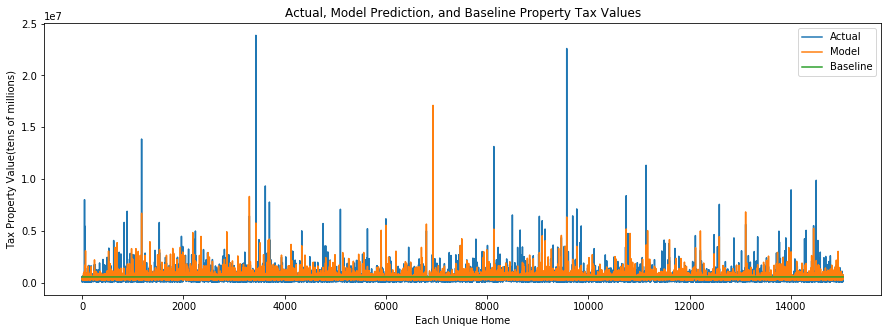

In [60]:
plt.figure(figsize=(15,5))
plt.title("Actual, Model Prediction, and Baseline Property Tax Values")
sns.lineplot(data = y_train.propertytaxvalue, label = "Actual")
sns.lineplot(data = y_train.yhat_poly, label = "Model")
sns.lineplot(data = y_train.yhat_baseline, label = "Baseline")
plt.xlabel('Each Unique Home')
plt.ylabel('Tax Property Value(tens of millions)')
plt.show()

## Conclusion